In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [2]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std|q_lvl_[0-6]_std').sum(axis=1)/(df.filter(regex='Entries').sum(axis=1))).fillna(0)
df['log_student_activity'] = np.log(df['student_activity'] +  1.0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  Remove all schools that have no IDACI rating
#df = df[pd.notnull(df['IDACI'])]

# Remove schools with low Entries
#df = df[(df.filter(regex='Entries')>10).all(axis=1)]

# Remove schools with high exam_score
#df = df[(df.filter(like='exam_score|2013_')<0.7).all(axis=1)]

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)


# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['student_activity']].quantile(0.95)
df_out = df[(df[q.keys()] < q).all(axis=1)]

print(df.shape)
df_out.head()


(899, 56)


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,q_lvl_2_cor_tch,view_concept_tch,q_lvl_3_cor_tch,q_lvl_2_tch,q_lvl_0_cor_tch,...,exam_improv_2013-2014_Biology,exam_improv_2013-2014_Mathematics,exam_improv_2013-2014_Chemistry,exam_improv_2013-2014_Physics,exam_improv_2013-2016_Biology,exam_improv_2013-2016_Mathematics,exam_improv_2013-2016_Chemistry,exam_improv_2013-2016_Physics,student_activity,log_student_activity
URN,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.036272,-0.003697,-0.061495,-0.099692,0.029736,-0.043330,-0.003100,-0.062738,1.531328,0.928744
100003,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,29.0,...,-0.080350,-0.020661,-0.019674,0.052747,-0.020112,-0.013455,-0.009502,0.106763,6.104000,1.960658
100054,5.0,1.0,1.0,1.0,19.7,1.0,8.0,1.0,3.0,0.0,...,0.138762,-0.006687,0.016362,0.015041,-0.035131,-0.017300,0.003301,-0.038957,3.130952,1.418508
100065,0.0,0.0,0.0,0.0,0.0,8.0,10.0,12.0,49.0,44.0,...,0.096233,0.001924,0.015242,0.059983,0.064762,-0.037641,0.037853,0.113732,10.724924,2.461717
100076,0.0,0.0,0.0,0.0,0.0,22.0,2.0,35.0,78.0,0.0,...,-0.107807,0.032783,-0.044749,-0.167057,-0.109535,-0.023395,-0.024589,-0.062783,0.162252,0.150359


In [3]:
def test_correlation(df, x_array, y_array, corrType):
    
    store_array = []
    
    for item_x in x_array:
        for item_y in y_array:
            score, pval = corrType(df[item_x],df[item_y])
            store_array.append([item_x, item_y, score,pval])
            
    df = pd.DataFrame(store_array,columns=['x','y','Correlation','P Value'])
            
    return df

# No outliers
print('Pearson Correlation')
print(test_correlation(df_out, ['student_activity','log_student_activity'], df_out.filter(regex='exam_improv').columns, pearsonr).sort_values('P Value'))

print('\nSpearman Correlation')
print(test_correlation(df_out, ['student_activity','log_student_activity'], df_out.filter(regex='exam_improv').columns, spearmanr).sort_values('P Value'))

print('\nKendall Correlation')
print(test_correlation(df_out, ['student_activity','log_student_activity'], df_out.filter(regex='exam_improv').columns, kendalltau).sort_values('P Value'))

Pearson Correlation
                       x                                  y  Correlation  \
15  log_student_activity      exam_improv_2013-2016_Physics     0.076949   
14  log_student_activity    exam_improv_2013-2016_Chemistry     0.067242   
6       student_activity    exam_improv_2013-2016_Chemistry     0.067026   
7       student_activity      exam_improv_2013-2016_Physics     0.061489   
13  log_student_activity  exam_improv_2013-2016_Mathematics     0.041154   
1       student_activity  exam_improv_2013-2014_Mathematics    -0.034527   
5       student_activity  exam_improv_2013-2016_Mathematics     0.032331   
11  log_student_activity      exam_improv_2013-2014_Physics     0.031032   
9   log_student_activity  exam_improv_2013-2014_Mathematics    -0.018247   
2       student_activity    exam_improv_2013-2014_Chemistry    -0.016725   
3       student_activity      exam_improv_2013-2014_Physics     0.016547   
12  log_student_activity      exam_improv_2013-2016_Biology     0.01

,Coef,R^2,X,Y,intercept
1,-0.000909,1.192086e-03,student_activity,exam_improv_2013-2014_Mathematics,0.006529
2,-0.000511,2.797303e-04,student_activity,exam_improv_2013-2014_Chemistry,0.002614
0,-0.000235,6.132814e-05,student_activity,exam_improv_2013-2014_Biology,0.005175
4,-0.000013,1.732826e-07,student_activity,exam_improv_2013-2016_Biology,0.000381
3,0.000617,2.738003e-04,student_activity,exam_improv_2013-2014_Physics,-0.005391
5,0.000867,1.045289e-03,student_activity,exam_improv_2013-2016_Mathematics,-0.019290
6,0.002244,4.492443e-03,student_activity,exam_improv_2013-2016_Chemistry,-0.011714
7,0.002487,3.780952e-03,student_activity,exam_improv_2013-2016_Physics,-0.013015


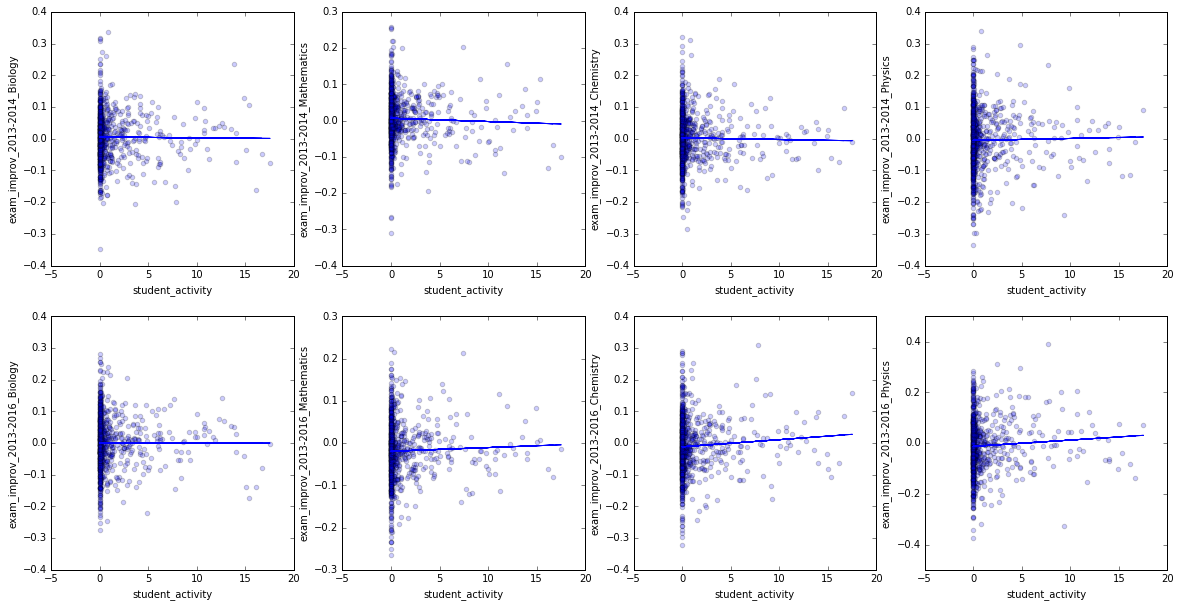

In [4]:
# Let's do a plot 

df_score = checkLinearFit(df_out,['student_activity'],df_out.filter(like='exam_improv').columns, n_cols=4, n_rows=2,figsize=(20,10))

df_score.sort_values('Coef')

,Coef,R^2,X,Y,intercept
7,0.011864,0.005921,log_student_activity,exam_improv_2013-2016_Physics,-0.015234
6,0.008583,0.004521,log_student_activity,exam_improv_2013-2016_Chemistry,-0.012808
3,0.004412,0.000963,log_student_activity,exam_improv_2013-2014_Physics,-0.006570
5,0.004205,0.001694,log_student_activity,exam_improv_2013-2016_Mathematics,-0.020094
4,0.001508,0.000152,log_student_activity,exam_improv_2013-2016_Biology,-0.000280
2,-0.000334,0.000008,log_student_activity,exam_improv_2013-2014_Chemistry,0.002170
0,-0.000558,0.000024,log_student_activity,exam_improv_2013-2014_Biology,0.005144
1,-0.001832,0.000333,log_student_activity,exam_improv_2013-2014_Mathematics,0.006269


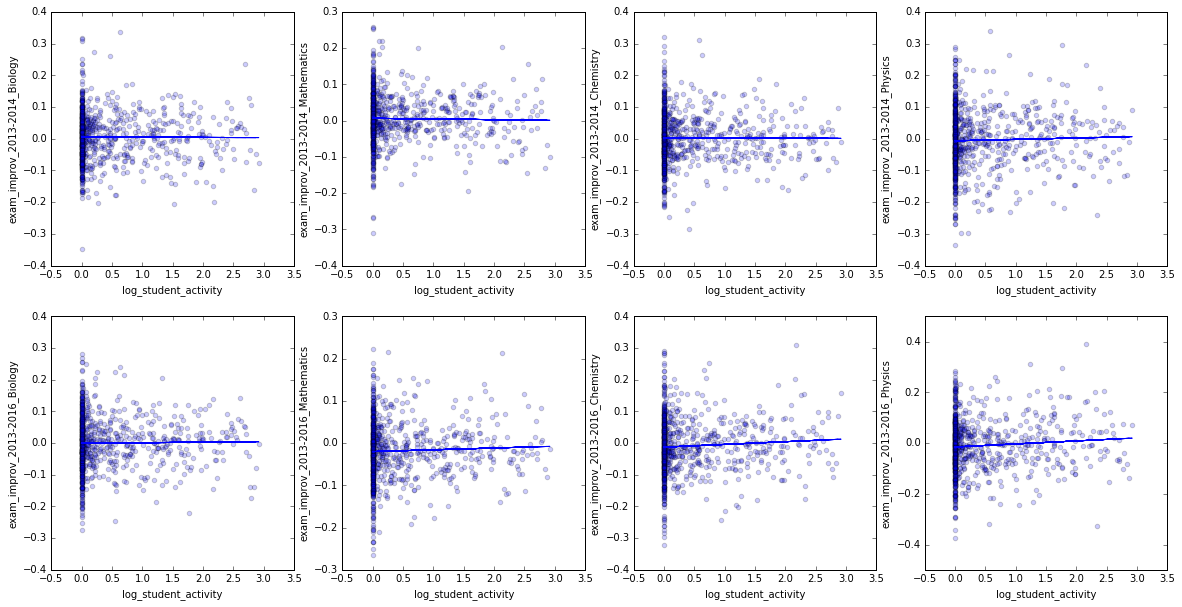

In [5]:
# Let's do a plot 

df_score = checkLinearFit(df_out,['log_student_activity'],df.filter(like='exam_improv').columns, n_cols=4, n_rows=2,figsize=(20,10))

df_score.sort_values('Coef').sort_values(by='Coef',ascending=False)

In [6]:
# There seems to be a noticeable difference for Physics, let's do a t-test

ttest_ind(df_out['exam_improv_2013-2014_Physics'],df_out['exam_improv_2013-2016_Physics'],equal_var=True)


Ttest_indResult(statistic=1.1137043383097183, pvalue=0.26556293242599593)

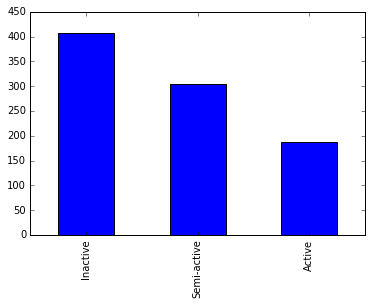

In [7]:
# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories


# ------------------------------------------------------
# Choose a feature and determine distribution
# ------------------------------------------------------

bins = [-0.1, 0, 2,10000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')



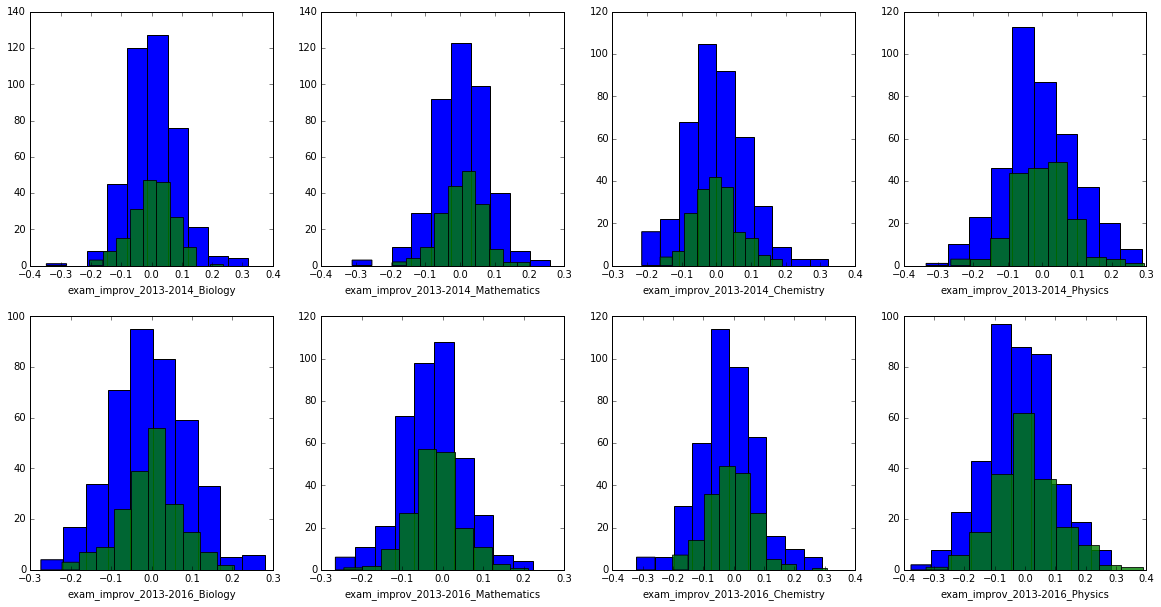

In [8]:
# Create a general function

def plotHistograms(feature_list,nrows, ncols, figsize=(20,10)):
    
    
    plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize);

    count = 1;
    for feature in feature_list:
        
        plt.subplot(nrows,ncols,count)
        plt.hist(df[df['categories']=='Inactive'][feature])
        plt.hist(df[df['categories']=='Active'][feature],alpha=0.8)
        plt.xlabel(feature)
        count += 1
    
plotHistograms(df.filter(regex='exam_improv').columns,2,4)

In [9]:
# Doing an F-test on all variables of interest

from sklearn.feature_selection import f_classif


df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
F, pval = f_classif(X, y)

df_score = pd.DataFrame({'Key':X.keys(),'F score':F,'p values':pval})

df_score.sort_values('p values')


,F score,Key,p values
7,6.030974e+00,exam_improv_2013-2016_Physics,0.014343
5,1.917304e+00,exam_improv_2013-2016_Mathematics,0.166675
6,1.540020e+00,exam_improv_2013-2016_Chemistry,0.215106
3,4.156630e-01,exam_improv_2013-2014_Physics,0.519358
4,1.498607e-01,exam_improv_2013-2016_Biology,0.698807
0,2.712611e-02,exam_improv_2013-2014_Biology,0.869236
1,7.481597e-03,exam_improv_2013-2014_Mathematics,0.931101
2,9.827464e-08,exam_improv_2013-2014_Chemistry,0.999750
